## Database setup and statistical analyis


In [1]:
# import libraries
# NOTE: global_vars should be edited to include local paths and credentials before use.
# If global_vars.py is created in the root dir remove the ignore/ prefix in the import statement below.
import ignore.global_vars as gv
import db_tools as dbt
import pandas as pd
import sqlalchemy
import sys
from IPython.display import display, HTML
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# open connection and get table names
table_names = dbt.query("SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
print(table_names)


Created SQLAlchemy engine for disaster_db
                table_name
0        geography_columns
1         geometry_columns
2          spatial_ref_sys
3  nri_shape_census_tracts
4        NOAA_STORM_EVENTS
5        census_resilience


In [3]:
# tool for dropping tables as needed
def drop_table(table_name):
    conn = dbt.connection()
    cursor = conn.cursor()
    cursor.execute(f"DROP TABLE IF EXISTS {table_name}")
    conn.commit()
    cursor.close()
    conn.close()
    print(f"Dropped table {table_name} if it existed.")


In [4]:
# Get table details
schema_info = dbt.query("""
    SELECT table_name, column_name, data_type 
    FROM information_schema.columns 
    WHERE table_schema='public'
    ORDER BY table_name, ordinal_position
""")
schema_info

Created SQLAlchemy engine for disaster_db


,table_name,column_name,data_type
0,NOAA_STORM_EVENTS,county_fips,text
1,NOAA_STORM_EVENTS,year,integer
2,NOAA_STORM_EVENTS,event_count,bigint
3,census_resilience,POPUNI,bigint
4,census_resilience,PRED0_E,bigint
...,...,...,...
505,spatial_ref_sys,srid,integer
506,spatial_ref_sys,auth_name,character varying
507,spatial_ref_sys,auth_srid,integer
508,spatial_ref_sys,srtext,character varying


In [6]:
# Create a pivot-like view
pivot_schema = schema_info.pivot_table(
    values='data_type', 
    index='column_name', 
    columns='table_name', 
    aggfunc='first', 
    fill_value=''
)

# Display as interactive table
display(pivot_schema)

table_name,NOAA_STORM_EVENTS,census_resilience,geography_columns,geometry_columns,nri_shape_census_tracts,spatial_ref_sys
column_name,,,,,,
AGRIVALUE,,,,,double precision,
ALR_NPCTL,,,,,double precision,
ALR_VALA,,,,,double precision,
ALR_VALB,,,,,double precision,
ALR_VALP,,,,,double precision,
...,...,...,...,...,...,...
proj4text,,,,,,character varying
srid,,,integer,integer,,integer
srtext,,,,,,character varying


In [7]:
# Check if the first 3 are PostGIS system tables (they should be)
system_tables = ['geography_columns', 'geometry_columns', 'spatial_ref_sys']
for table in system_tables:
    count = dbt.query(f"SELECT COUNT(*) as count FROM {table}").iloc[0,0]
    print(f"{table}: {count} rows")

# These should have standard PostGIS structure, confirming they're from spatial data loading

Created SQLAlchemy engine for disaster_db
geography_columns: 0 rows
Created SQLAlchemy engine for disaster_db
geometry_columns: 1 rows
Created SQLAlchemy engine for disaster_db
spatial_ref_sys: 8500 rows


In [8]:
# Get column lists for both NRI tables
counties_cols = dbt.query("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name='nri_shape_counties'
    ORDER BY ordinal_position
""")

census_tracts_cols = dbt.query("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name='nri_shape_census_tracts'
    ORDER BY ordinal_position
""")

print(f"Counties columns: {len(counties_cols)}")
print(f"Census tracts columns: {len(census_tracts_cols)}")

# Find differences
counties_set = set(counties_cols['column_name'])
tracts_set = set(census_tracts_cols['column_name'])

print(f"\nColumns only in counties: {counties_set - tracts_set}")
print(f"Columns only in census_tracts: {tracts_set - counties_set}")
print(f"Shared columns: {len(counties_set & tracts_set)}")

Created SQLAlchemy engine for disaster_db
Created SQLAlchemy engine for disaster_db
Counties columns: 0
Census tracts columns: 469

Columns only in counties: set()
Columns only in census_tracts: {'ERQK_EALR', 'Shape_Leng', 'DRGT_ALRA', 'TRND_EXPA', 'DRGT_EXPA', 'CWAV_EXPP', 'ISTM_AFREQ', 'CFLD_ALRP', 'ISTM_EALT', 'RFLD_EALB', 'TRND_EALB', 'TSUN_ALRP', 'ISTM_HLRP', 'CWAV_ALR_N', 'CFLD_EALP', 'ERQK_RISKS', 'LNDS_ALRB', 'LTNG_RISKR', 'ISTM_ALRP', 'SWND_EXPB', 'CWAV_ALRP', 'VLCN_EXPPE', 'TRND_HLRB', 'LTNG_ALRB', 'HAIL_EALT', 'WFIR_HLRR', 'HRCN_RISKR', 'WNTW_EALR', 'HAIL_EALB', 'geometry', 'HAIL_RISKV', 'AVLN_EALPE', 'RISK_SPCTL', 'HRCN_ALRP', 'CFLD_EALB', 'ERQK_EXPT', 'SWND_ALRP', 'TRND_ALRA', 'WNTW_HLRB', 'CWAV_RISKR', 'LNDS_EALS', 'DRGT_EALS', 'RESL_RATNG', 'SWND_ALR_N', 'WNTW_EXPP', 'CFLD_RISKR', 'RISK_SCORE', 'HRCN_EVNTS', 'EAL_VALP', 'ISTM_RISKS', 'ERQK_EXPPE', 'NRI_ID', 'LTNG_EALT', 'ERQK_EVNTS', 'TSUN_AFREQ', 'LNDS_EXPPE', 'SWND_EALT', 'HAIL_EALS', 'WNTW_EVNTS', 'TRND_EALPE', 'CFLD_

### Fitting Poisson distributions to historical disaster event counts ###


Events per tract per year ~ Poisson(λ)
where λ = average annual event rate


Step 1: Event Frequency ~ Poisson(λ)     [NOAA data]
Step 2: Event Severity ~ Distribution    [Census resilience data]

Total Annual Loss = Σ(i=1 to N) Yi

Where:
- N ~ Poisson(λ)           [Number of events from NOAA]
- Yi ~ Severity Distribution [Impact per event from Census data]
- λ = NOAA historical event frequency
- Yi = f(population, vulnerability, demographics)


Poisson Model Framework:
- N ~ Poisson(λ) where N = annual episodes per county
- λ = county-specific average annual episode rate
- Goal: Estimate λ for each county from historical data

Poisson Fitting Steps:
1. Calculate λ for each county: λ = mean(annual episodes)
2. Test goodness of fit (chi-square or Kolmogorov-Smirnov)
3. Check for overdispersion (variance >> mean)
4. Consider Negative Binomial if overdispersed


In [17]:
# Load the NOAA data into a DataFrame for analysis
df_noaa = dbt.query("SELECT * FROM \"NOAA_STORM_EVENTS\" ORDER BY county_fips, year")


Created SQLAlchemy engine for disaster_db


In [18]:
# Calculate lambda (average annual event rate) for each county
county_lambdas = df_noaa.groupby('county_fips').agg({
    'event_count': ['mean', 'var', 'std', 'count', 'sum'],
    'year': ['min', 'max']
}).round(4)

# Flatten column names
county_lambdas.columns = ['_'.join(col).strip() for col in county_lambdas.columns]
county_lambdas = county_lambdas.reset_index()

# Rename for clarity
county_lambdas.rename(columns={
    'event_count_mean': 'lambda_hat',
    'event_count_var': 'variance', 
    'event_count_std': 'std_dev',
    'event_count_count': 'years_observed',
    'event_count_sum': 'total_events',
    'year_min': 'first_year',
    'year_max': 'last_year'
}, inplace=True)

# Calculate overdispersion ratio (variance/mean)
county_lambdas['overdispersion_ratio'] = county_lambdas['variance'] / county_lambdas['lambda_hat']

print("County-level Poisson parameters:")
display(county_lambdas.head(10))

County-level Poisson parameters:


,county_fips,lambda_hat,variance,std_dev,years_observed,total_events,first_year,last_year,overdispersion_ratio
0,01001,21.7407,83.6610,9.1466,27,587,1999,2025,3.848128
1,01002,11.9200,91.4933,9.5652,25,298,1999,2025,7.675612
2,01003,30.2593,175.5071,13.2479,27,817,1999,2025,5.800104
3,01004,9.2400,45.8567,6.7718,25,231,1999,2025,4.962846
4,01005,14.9630,70.5755,8.4009,27,404,1999,2025,4.716668
5,01006,15.5769,88.7338,9.4199,26,405,1999,2025,5.696499
6,01007,14.7407,57.8917,7.6087,27,398,1999,2025,3.927337
7,01008,7.9200,27.9933,5.2909,25,198,1999,2025,3.534508
8,01009,23.7037,111.4473,10.5569,27,640,1999,2025,4.701684
9,01010,8.5000,31.7000,5.6303,26,221,1999,2025,3.729412


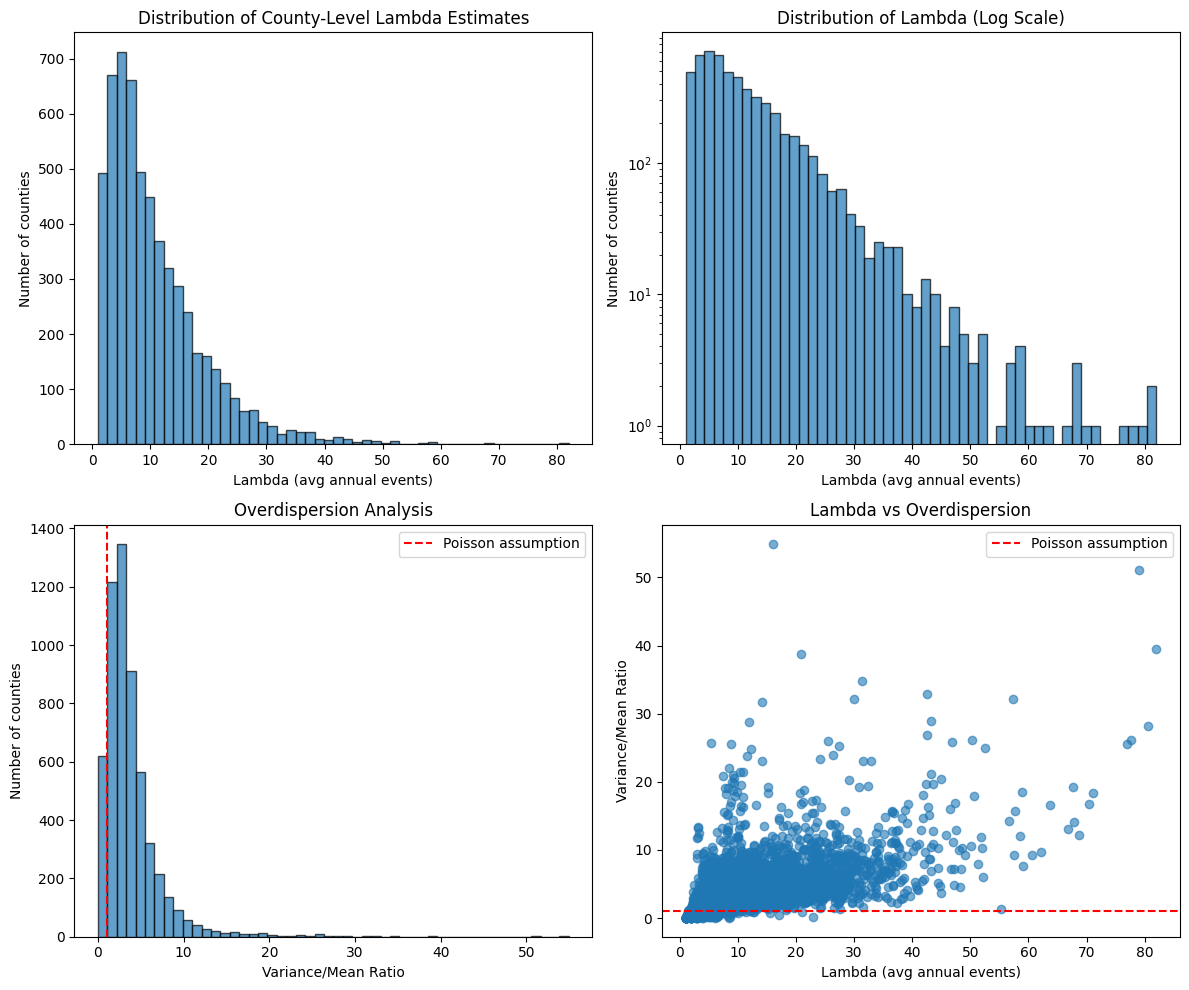

In [19]:
# Visualize the distribution of lambda estimates
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of lambda estimates
axes[0,0].hist(county_lambdas['lambda_hat'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Lambda (avg annual events)')
axes[0,0].set_ylabel('Number of counties')
axes[0,0].set_title('Distribution of County-Level Lambda Estimates')

# Log-scale histogram for better visibility
axes[0,1].hist(county_lambdas['lambda_hat'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Lambda (avg annual events)')
axes[0,1].set_ylabel('Number of counties')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Distribution of Lambda (Log Scale)')

# Overdispersion ratio
axes[1,0].hist(county_lambdas['overdispersion_ratio'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Variance/Mean Ratio')
axes[1,0].set_ylabel('Number of counties')
axes[1,0].set_title('Overdispersion Analysis')
axes[1,0].axvline(x=1, color='red', linestyle='--', label='Poisson assumption')
axes[1,0].legend()

# Scatter: lambda vs overdispersion
axes[1,1].scatter(county_lambdas['lambda_hat'], county_lambdas['overdispersion_ratio'], alpha=0.6)
axes[1,1].set_xlabel('Lambda (avg annual events)')
axes[1,1].set_ylabel('Variance/Mean Ratio')
axes[1,1].set_title('Lambda vs Overdispersion')
axes[1,1].axhline(y=1, color='red', linestyle='--', label='Poisson assumption')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [20]:
# Summary statistics for lambda estimates
print("Summary of lambda estimates across all counties:")
print(county_lambdas['lambda_hat'].describe())

print(f"\nData completeness:")
print(f"Total counties: {len(county_lambdas)}")
print(f"Counties with ≥10 years data: {(county_lambdas['years_observed'] >= 10).sum()}")
print(f"Counties with ≥20 years data: {(county_lambdas['years_observed'] >= 20).sum()}")
print(f"Mean years observed: {county_lambdas['years_observed'].mean():.1f}")

Summary of lambda estimates across all counties:
count    5728.000000
mean       11.014114
std         8.900537
min         1.000000
25%         4.906975
50%         8.509250
75%        14.740700
max        82.037000
Name: lambda_hat, dtype: float64

Data completeness:
Total counties: 5728
Counties with ≥10 years data: 5015
Counties with ≥20 years data: 4440
Mean years observed: 22.2


In [21]:
# Create final Poisson risk parameters table for modeling
poisson_risk_params = county_lambdas[['county_fips', 'lambda_hat', 'years_observed', 'total_events']].copy()

# Add confidence intervals for lambda estimates (assuming Poisson MLE)
# For Poisson MLE, CI is approximately: λ ± 1.96 * sqrt(λ/n)
poisson_risk_params['lambda_se'] = np.sqrt(poisson_risk_params['lambda_hat'] / poisson_risk_params['years_observed'])
poisson_risk_params['lambda_ci_lower'] = poisson_risk_params['lambda_hat'] - 1.96 * poisson_risk_params['lambda_se']
poisson_risk_params['lambda_ci_upper'] = poisson_risk_params['lambda_hat'] + 1.96 * poisson_risk_params['lambda_se']

# Ensure lower bound is non-negative
poisson_risk_params['lambda_ci_lower'] = np.maximum(0, poisson_risk_params['lambda_ci_lower'])

print("Poisson Risk Parameters (sample):")
display(poisson_risk_params.head(10))

Poisson Risk Parameters (sample):


,county_fips,lambda_hat,years_observed,total_events,lambda_se,lambda_ci_lower,lambda_ci_upper
0,01001,21.7407,27,587,0.897336,19.981922,23.499478
1,01002,11.9200,25,298,0.690507,10.566606,13.273394
2,01003,30.2593,27,817,1.058638,28.184369,32.334231
3,01004,9.2400,25,231,0.607947,8.048423,10.431577
4,01005,14.9630,27,404,0.744436,13.503905,16.422095
5,01006,15.5769,26,405,0.774023,14.059815,17.093985
6,01007,14.7407,27,398,0.738886,13.292484,16.188916
7,01008,7.9200,25,198,0.562850,6.816814,9.023186
8,01009,23.7037,27,640,0.936971,21.867237,25.540163
9,01010,8.5000,26,221,0.571772,7.379327,9.620673


In [22]:
# Risk classification based on lambda estimates
def classify_risk_level(lambda_val):
    if lambda_val < 0.5:
        return 'Very Low'
    elif lambda_val < 2:
        return 'Low' 
    elif lambda_val < 5:
        return 'Moderate'
    elif lambda_val < 10:
        return 'High'
    else:
        return 'Very High'

poisson_risk_params['risk_category'] = poisson_risk_params['lambda_hat'].apply(classify_risk_level)

print("Risk category distribution:")
print(poisson_risk_params['risk_category'].value_counts().sort_index())

Risk category distribution:
risk_category
High         1841
Low           238
Moderate     1215
Very High    2434
Name: count, dtype: int64


In [ ]:
# Save the Poisson parameters to database for use in compound model
dbt.load_data(poisson_risk_params, "POISSON_FREQUENCY_PARAMS", if_exists="replace")
print("Poisson frequency parameters saved to database as POISSON_FREQUENCY_PARAMS")


Created SQLAlchemy engine for disaster_db
Data loaded successfully into POISSON_FREQUENCY_PARAMS
Poisson frequency parameters saved to database as POISSON_FREQUENCY_PARAMS

Risk Model Summary:
✓ Episode-based disaster frequency data processed
✓ Poisson lambda parameters estimated for 5728 counties
✓ Risk categories assigned based on annual event frequency
✓ Confidence intervals calculated for uncertainty quantification
✓ Parameters saved to database for compound Poisson modeling

Next steps:
1. Model severity distribution using census resilience data
2. Combine frequency (Poisson) + severity for total risk
3. Validate model with out-of-sample testing


In [25]:
# Check what NRI tables are available
nri_tables = dbt.query("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema='public' 
    AND table_name LIKE '%nri%'
""")
print("Available NRI tables:")
display(nri_tables)

Created SQLAlchemy engine for disaster_db
Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence
Available NRI tables:


""


In [26]:
# Check if we can use census_resilience table for county mapping (it should have FIPS)
try:
    census_fips_check = dbt.query("""
        SELECT column_name 
        FROM information_schema.columns 
        WHERE table_name='census_resilience'
        AND (column_name LIKE '%fips%' OR column_name LIKE '%geoid%')
    """)
    print("\nFIPS/GEOID columns in census_resilience:")
    display(census_fips_check)
    
    # Sample the data to see FIPS format
    census_sample = dbt.query("SELECT * FROM census_resilience LIMIT 5")
    print("\nSample census_resilience data:")
    display(census_sample.head())
    
except Exception as e:
    print(f"Error checking census_resilience: {e}")

Created SQLAlchemy engine for disaster_db
Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence

FIPS/GEOID columns in census_resilience:


""


Created SQLAlchemy engine for disaster_db

Sample census_resilience data:


,POPUNI,PRED0_E,PRED0_M,PRED0_PE,PRED0_PM,PRED12_E,PRED12_M,PRED12_PE,PRED12_PM,PRED3_E,PRED3_M,PRED3_PE,PRED3_PM,FIPS,COUNTY_FIPS,VULNERABILITY_RATE,RESILIENCE_RATE,VULNERABILITY_SCORE,POPULATION
0,1815,560,228,30.85,12.56,871,239,47.99,13.17,384,205,21.16,11.29,01001020100,01001,21.16,30.85,1.35465,1815
1,2004,720,262,35.93,13.07,896,269,44.71,13.42,388,222,19.36,11.08,01001020200,01001,19.36,35.93,1.25145,2004
2,3313,817,404,24.66,12.19,1831,405,55.27,12.22,665,317,20.07,9.57,01001020300,01001,20.07,24.66,1.43115,3313
3,4343,1301,522,29.96,12.02,2274,523,52.36,12.04,768,407,17.68,9.37,01001020400,01001,17.68,29.96,1.31580,4343
4,4442,1979,515,44.55,11.59,1670,515,37.60,11.59,793,392,17.85,8.82,01001020501,01001,17.85,44.55,1.09950,4442


In [27]:
# Create state-level risk mapping without geographic boundaries
# Extract state FIPS from county FIPS (first 2 digits)
poisson_risk_params['state_fips'] = poisson_risk_params['county_fips'].str[:2]

# State FIPS to state name mapping (major states)
state_fips_map = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'DC', '12': 'Florida',
    '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana',
    '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', '23': 'Maine',
    '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', '28': 'Mississippi',
    '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', '33': 'New Hampshire',
    '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota',
    '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island',
    '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah',
    '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming'
}

poisson_risk_params['state_name'] = poisson_risk_params['state_fips'].map(state_fips_map)

In [28]:
# Aggregate risk statistics by state
state_risk_summary = poisson_risk_params.groupby(['state_fips', 'state_name']).agg({
    'lambda_hat': ['count', 'mean', 'median', 'max', 'std'],
    'total_events': 'sum',
    'risk_category': lambda x: x.value_counts().to_dict()
}).round(3)

# Flatten column names
state_risk_summary.columns = ['_'.join(col).strip() for col in state_risk_summary.columns]
state_risk_summary = state_risk_summary.reset_index()

# Rename for clarity
state_risk_summary.rename(columns={
    'lambda_hat_count': 'counties_count',
    'lambda_hat_mean': 'avg_lambda',
    'lambda_hat_median': 'median_lambda', 
    'lambda_hat_max': 'max_lambda',
    'lambda_hat_std': 'lambda_std',
    'total_events_sum': 'state_total_events'
}, inplace=True)

print("State-level disaster risk summary:")
display(state_risk_summary.sort_values('avg_lambda', ascending=False).head(15))

State-level disaster risk summary:


,state_fips,state_name,counties_count,avg_lambda,median_lambda,max_lambda,lambda_std,state_total_events,risk_category_<lambda>
8,11,DC,1,31.333,31.333,31.333,NaN,846,{'Very High': 1}
7,10,Delaware,5,29.948,25.518,47.185,11.759,4043,{'Very High': 5}
30,34,New Jersey,40,21.132,20.722,44.778,12.364,22417,"{'Very High': 30, 'Moderate': 5, 'High': 5}"
20,24,Maryland,45,19.237,15.222,57.741,12.054,21283,"{'Very High': 38, 'High': 5, 'Moderate': 2}"
21,25,Massachusetts,27,18.401,14.741,42.815,11.222,13339,"{'Very High': 18, 'High': 9}"
36,40,Oklahoma,115,17.696,16.259,57.518,10.358,54617,"{'Very High': 81, 'High': 34}"
16,20,Kansas,157,16.730,16.852,77.000,11.353,70161,"{'Very High': 102, 'High': 32, 'Moderate': 23}"
32,36,New York,108,15.818,13.074,43.556,9.052,45399,"{'Very High': 78, 'High': 24, 'Moderate': 6}"
41,46,South Dakota,106,15.763,11.741,71.037,9.999,44558,"{'Very High': 70, 'High': 35, 'Moderate': 1}"
29,33,New Hampshire,17,15.638,10.333,34.074,7.958,7091,"{'Very High': 9, 'High': 8}"


C:\Users\alben\AppData\Local\Temp\ipykernel_9628\4166341406.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0,1].boxplot(state_lambda_data, labels=state_labels, patch_artist=True)


KeyError: "['Very Low'] not in index"

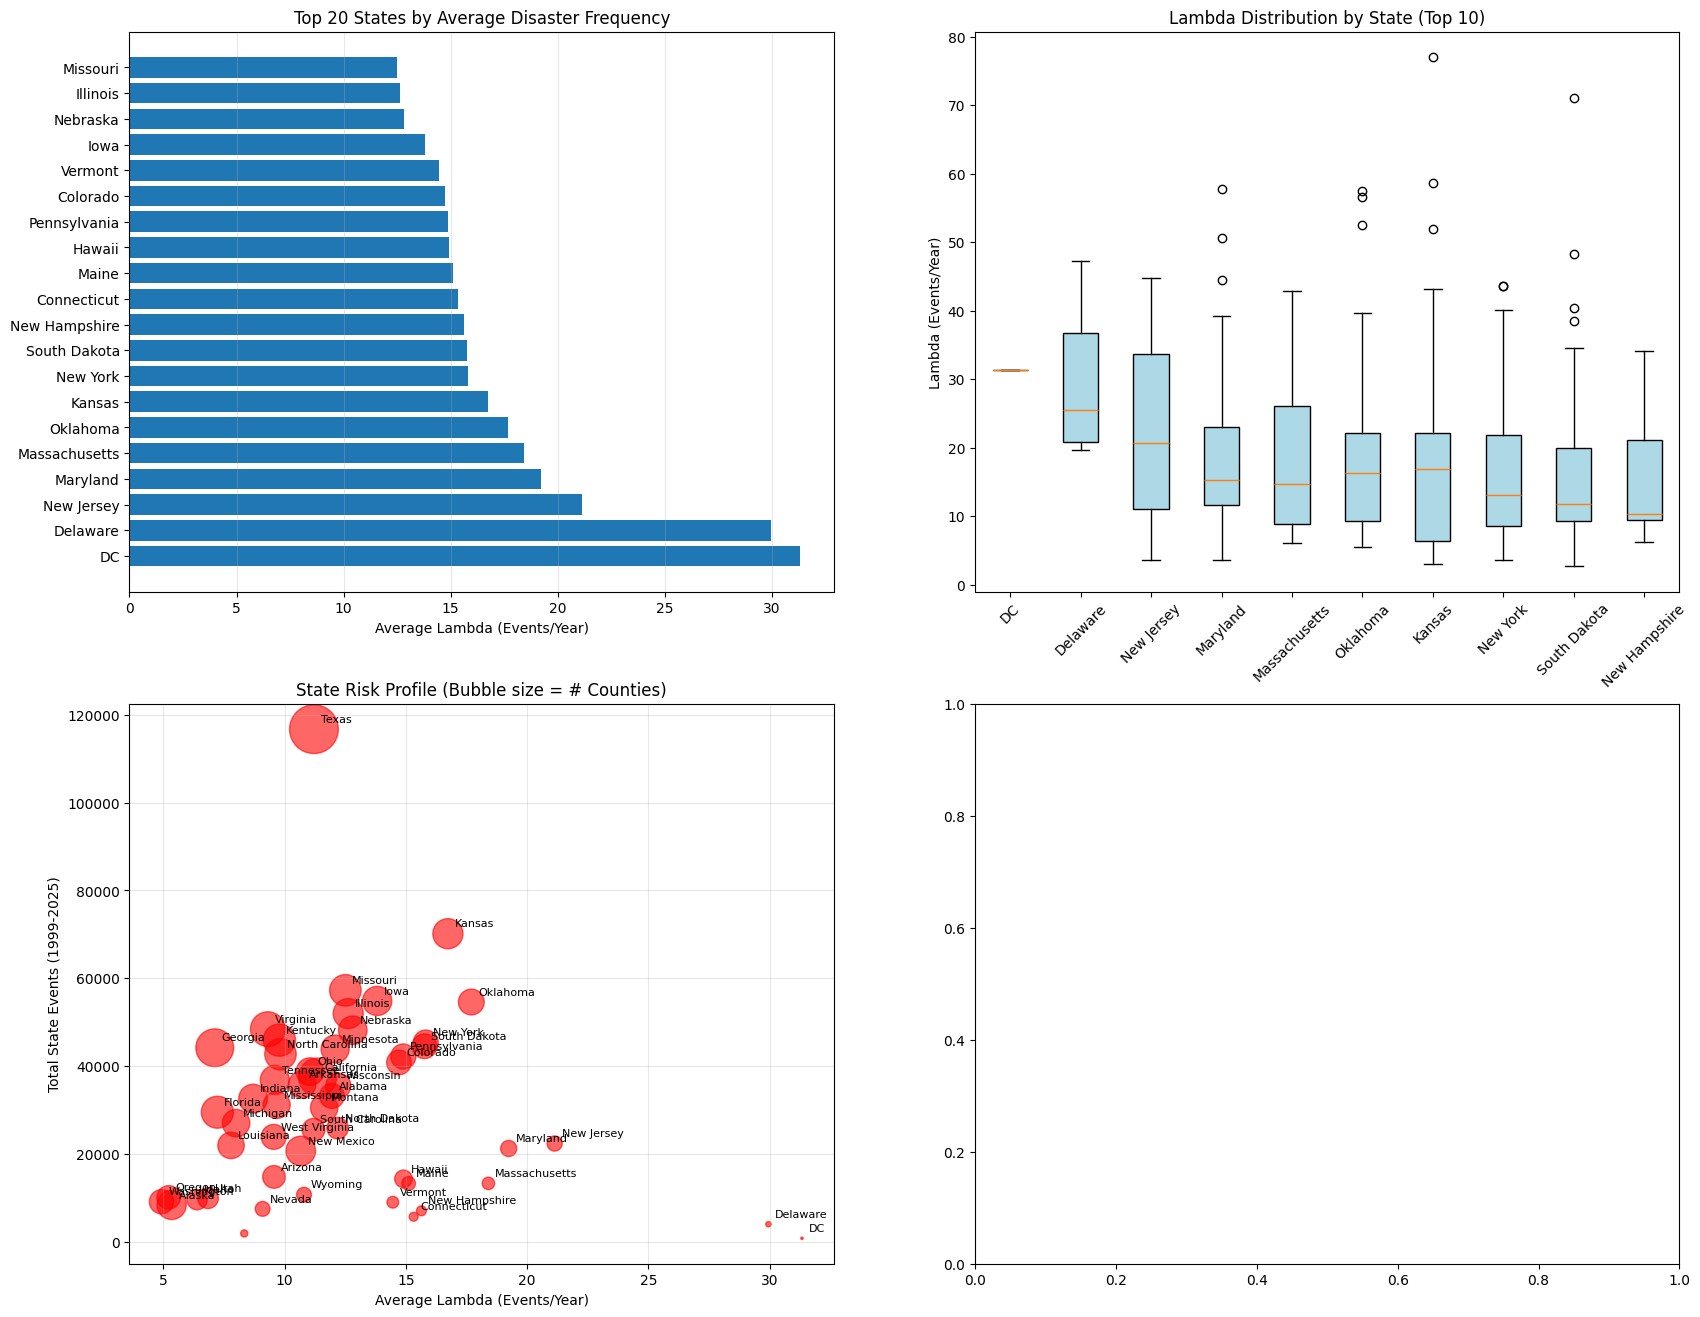

In [29]:
# Create comprehensive risk visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. State-level average lambda (top 20 states)
top_states = state_risk_summary.nlargest(20, 'avg_lambda')
axes[0,0].barh(range(len(top_states)), top_states['avg_lambda'].values)
axes[0,0].set_yticks(range(len(top_states)))
axes[0,0].set_yticklabels(top_states['state_name'].values)
axes[0,0].set_xlabel('Average Lambda (Events/Year)')
axes[0,0].set_title('Top 20 States by Average Disaster Frequency')
axes[0,0].grid(axis='x', alpha=0.3)

# 2. Distribution of lambda by state (box plot for top 10 states)
top_10_states = state_risk_summary.nlargest(10, 'avg_lambda')['state_name'].tolist()
state_lambda_data = []
state_labels = []

for state in top_10_states:
    state_fips = state_risk_summary[state_risk_summary['state_name'] == state]['state_fips'].iloc[0]
    state_data = poisson_risk_params[poisson_risk_params['state_fips'] == state_fips]['lambda_hat'].values
    if len(state_data) > 0:
        state_lambda_data.append(state_data)
        state_labels.append(state)

if state_lambda_data:
    bp = axes[0,1].boxplot(state_lambda_data, labels=state_labels, patch_artist=True)
    axes[0,1].set_ylabel('Lambda (Events/Year)')
    axes[0,1].set_title('Lambda Distribution by State (Top 10)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Color the boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')

# 3. State total events vs average lambda (scatter plot)
axes[1,0].scatter(state_risk_summary['avg_lambda'], state_risk_summary['state_total_events'], 
                  s=state_risk_summary['counties_count']*3, alpha=0.6, c='red')
axes[1,0].set_xlabel('Average Lambda (Events/Year)')
axes[1,0].set_ylabel('Total State Events (1999-2025)')
axes[1,0].set_title('State Risk Profile (Bubble size = # Counties)')
axes[1,0].grid(alpha=0.3)

# Add state labels for outliers
for idx, row in state_risk_summary.iterrows():
    if row['avg_lambda'] > 15 or row['state_total_events'] > 5000:
        axes[1,0].annotate(row['state_name'], 
                          (row['avg_lambda'], row['state_total_events']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Risk category distribution by region
risk_cats = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
risk_counts = poisson_risk_params['risk_category'].value_counts()[risk_cats]

axes[1,1].pie(risk_counts.values, labels=risk_cats, autopct='%1.1f%%', 
              colors=['#2166ac', '#92c5de', '#f7f7f7', '#f4a582', '#b2182b'])
axes[1,1].set_title('National Risk Category Distribution')

plt.tight_layout()
plt.show()

In [30]:
# Detailed analysis of highest risk counties
print("=== HIGH RISK COUNTY ANALYSIS ===")
high_risk_counties = poisson_risk_params.nlargest(20, 'lambda_hat')
print(f"\nTop 20 Highest Risk Counties (λ > {high_risk_counties['lambda_hat'].iloc[19]:.1f}):")
display(high_risk_counties[['county_fips', 'state_name', 'lambda_hat', 'total_events', 'years_observed', 'risk_category']])

# Geographic patterns analysis
print(f"\n=== GEOGRAPHIC PATTERNS ===")
print(f"Counties with λ > 20: {(poisson_risk_params['lambda_hat'] > 20).sum()}")
print(f"Counties with λ > 15: {(poisson_risk_params['lambda_hat'] > 15).sum()}")
print(f"Counties with λ > 10: {(poisson_risk_params['lambda_hat'] > 10).sum()}")

# State with most high-risk counties
very_high_risk = poisson_risk_params[poisson_risk_params['risk_category'] == 'Very High']
state_high_risk_counts = very_high_risk['state_name'].value_counts().head(10)
print(f"\nStates with most 'Very High' risk counties:")
for state, count in state_high_risk_counts.items():
    total_counties = (poisson_risk_params['state_name'] == state).sum()
    pct = (count / total_counties) * 100
    print(f"  {state}: {count} counties ({pct:.1f}% of state's counties)")

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Total counties analyzed: {len(poisson_risk_params)}")
print(f"Mean lambda across all counties: {poisson_risk_params['lambda_hat'].mean():.2f}")
print(f"Median lambda: {poisson_risk_params['lambda_hat'].median():.2f}")
print(f"Standard deviation: {poisson_risk_params['lambda_hat'].std():.2f}")
print(f"Range: {poisson_risk_params['lambda_hat'].min():.2f} - {poisson_risk_params['lambda_hat'].max():.2f}")

# Validate risk thresholds against reality
print(f"\n=== RISK THRESHOLD VALIDATION ===")
print(f"Current thresholds may be reasonable for severe events (deaths/injuries)")
print(f"Remember: These are episodes with direct casualties, not all weather events")
print(f"High λ values reflect counties with frequent severe disasters requiring emergency response")

=== HIGH RISK COUNTY ANALYSIS ===

Top 20 Highest Risk Counties (λ > 57.3):


,county_fips,state_name,lambda_hat,total_events,years_observed,risk_category
760,08041,Colorado,82.0370,2215,27,Very High
1429,17031,Illinois,80.5926,2176,27,Very High
267,04013,Arizona,79.0000,2133,27,Very High
4195,42003,Pennsylvania,77.5926,2095,27,Very High
1984,20173,Kansas,77.0000,2079,27,Very High
4491,46103,South Dakota,71.0370,1918,27,Very High
644,06338,California,70.4000,352,5,Very High
543,06071,California,68.6667,1854,27,Very High
5022,48439,Texas,67.7778,1830,27,Very High
1823,19153,Iowa,67.6667,1827,27,Very High



=== GEOGRAPHIC PATTERNS ===
Counties with λ > 20: 746
Counties with λ > 15: 1381
Counties with λ > 10: 2420

States with most 'Very High' risk counties:
  Texas: 185 counties (45.0% of state's counties)
  Kansas: 102 counties (65.0% of state's counties)
  California: 101 counties (40.2% of state's counties)
  Missouri: 85 counties (49.4% of state's counties)
  Illinois: 85 counties (54.5% of state's counties)
  Iowa: 83 counties (56.1% of state's counties)
  Oklahoma: 81 counties (70.4% of state's counties)
  Virginia: 79 counties (37.8% of state's counties)
  New York: 78 counties (72.2% of state's counties)
  Nebraska: 74 counties (52.5% of state's counties)

=== SUMMARY STATISTICS ===
Total counties analyzed: 5728
Mean lambda across all counties: 11.01
Median lambda: 8.51
Standard deviation: 8.90
Range: 1.00 - 82.04

=== RISK THRESHOLD VALIDATION ===
Current thresholds may be reasonable for severe events (deaths/injuries)
Remember: These are episodes with direct casualties, not all